In [1]:
try:
    import IPython
except:
    %pip install IPython
    import IPython 
from IPython.display import display, IFrame, HTML, Javascript
HTML("""<link rel="stylesheet" type="text/css" href="src/css/notebook.css"/>""")

#  Transforming John Ruskin Collection Data to Linked Art 

This notebook transforms collections data to a Linked Art representation for artworks by John Ruskin. The data origin collections data published in various formats by museums and galleries. 

- CSV
 - National Gallery of Art (NGA), Washington, USA
 - Cleveland Museum of Art, USA
- JSON
 - The Tate Museum, UK
 - Harvard Museum, USA 
 - Rijksmuseum, Netherlands
- HTML 
 - Ashmolean Museum, UK
 


## Transformation Process
The transformation process common to all data sources:
- read collection data into Python dictionary
- create a mapping between entities in the Python dictionary and entities in the Linked Art data model
- use the mapping together with `createObjDesc()`, `cromulent` Python library, and custom coding in the `createObjProp()` function, to create a Linked Art JSON-LD representation
- write to file

In [2]:
# output directory for files created
outputdir = "./data/ruskin/output/json/"

images = {}

## National Gallery of Art (NGA), Washington, United States

The collection data exists into two files:
- CSV data file containing artwork description  [data file](./data/nga/input/nga_ruskin.csv)
- CSV data file containing detailed digital image information for artworks https://raw.githubusercontent.com/NationalGalleryOfArt/opendata/main/data/published_images.csv


 #### Further Reading 
 
 - National Gallery of Art https://www.nga.gov/
 - NGA GitHub https://github.com/NationalGalleryOfArt

### Load NGA Collection Data into DataFrame

In [3]:
try:
    import pandas as pd
except:
    %pip install pandas
    import pandas as pd
    
fileNGA = 'data/nga/input/nga_ruskin.csv'

dataFrameNGA = pd.read_csv(fileNGA)
dataFrameNGA.head()

objectid  accessioned accessionnum  locationid  \
0     70238            1    1987.73.2         NaN   
1     70367            1   1988.20.38         NaN   
2     72870            1    1991.88.1         NaN   
3     76140            1  1995.52.158         NaN   

                                               title displaydate  beginyear  \
0                     Tower of the Cathedral at Sens     c. 1845       1845   
1                                         Tree Study   mid-1850s       1845   
2            The Garden of San Miniato near Florence        1845       1845   
3  Ornamental Study with Acanthus Motif for "The ...        1849       1849   

   endyear visualbrowsertimespan  \
0     1845          1826 to 1850   
1     1855          1826 to 1850   
2     1845          1826 to 1850   
3     1849          1826 to 1850   

                                              medium  ...  \
0  pen and brown ink, brush and black ink, black ...  ...   
1  pen and black ink with blue-gray and gray wash...  ...   
2  watercolor and pen and black ink, heightened w...  ...   
3  pen and brown ink with watercolor and graphite...  ...   

  visualbrowserclassification parentid  isvirtual departmentabbr portfolio  \
0                     drawing      NaN          0           CG-E       NaN   
1                     drawing      NaN          0           CG-E       NaN   
2                     drawing      NaN          0           CG-E       NaN   
3                     drawing      NaN          0           CG-E       NaN   

  series volume  watermarks    lastdetectedmodification  customprinturl  
0    NaN    NaN         NaN  2019-10-28 22:01:34.883-04             NaN  
1    NaN    NaN         NaN  2020-04-10 22:01:40.093-04             NaN  
2    NaN    NaN         NaN  2019-10-28 22:01:34.883-04             NaN  
3    NaN    NaN         NaN  2019-10-28 22:01:34.883-04             NaN  

[4 rows x 28 columns]

### Load NGA Digital Image File into DataFrame

The data file containing detailed digital image data is loaded into a pandas dataframe `dataFrameNGAImages`

In [4]:
fileNGAimages = "https://raw.githubusercontent.com/NationalGalleryOfArt/opendata/main/data/published_images.csv"
dataFrameNGAImages = pd.read_csv(fileNGAimages)
dataFrameNGAImages.head()

uuid  \
0  00004dec-8300-4487-8d89-562d0126b6a1   
1  00007f61-4922-417b-8f27-893ea328206c   
2  0000bd8c-39de-4453-b55d-5e28a9beed38   
3  0000e5a4-7d32-4c2a-97c6-a6b571c9fd71   
4  0001668a-dd1c-48e8-9267-b6d1697d43c8   

                                             iiifurl  \
0  https://api.nga.gov/iiif/00004dec-8300-4487-8d...   
1  https://api.nga.gov/iiif/00007f61-4922-417b-8f...   
2  https://api.nga.gov/iiif/0000bd8c-39de-4453-b5...   
3  https://api.nga.gov/iiif/0000e5a4-7d32-4c2a-97...   
4  https://api.nga.gov/iiif/0001668a-dd1c-48e8-92...   

                                        iiifthumburl viewtype  sequence  \
0  https://api.nga.gov/iiif/00004dec-8300-4487-8d...  primary       0.0   
1  https://api.nga.gov/iiif/00007f61-4922-417b-8f...  primary       0.0   
2  https://api.nga.gov/iiif/0000bd8c-39de-4453-b5...  primary       0.0   
3  https://api.nga.gov/iiif/0000e5a4-7d32-4c2a-97...  primary       0.0   
4  https://api.nga.gov/iiif/0001668a-dd1c-48e8-92...  primary       0.0   

   width  height  maxpixels                 created  \
0   2623    4000      640.0  2010-09-07 15:08:48-04   
1   3365    4332        NaN  2013-07-05 15:41:08-04   
2   3500    4688        NaN  2013-08-05 14:31:59-04   
3   2252    3000        NaN  2013-03-18 14:39:55-04   
4   3446    4448        NaN  2014-01-02 14:50:50-05   

                     modified  depictstmsobjectid assistivetext  
0  2022-04-21 12:57:43.657-04               11975           NaN  
1      2022-05-23 14:59:28-04               17387           NaN  
2      2022-05-23 15:05:58-04               19245           NaN  
3      2022-05-17 18:19:25-04              153987           NaN  
4      2022-05-23 15:39:38-04               23830           NaN

### Remove Byte Order Marks and Define Data Mapping

Remove Byte Order Marks and create Python dictionary containing data mapping for each input file.

In [5]:


# remove BOM

removeBOM = open(fileNGA, mode='r', encoding='utf-8-sig').read()
open(fileNGA, mode='w', encoding='utf-8').write(removeBOM)


# data mapping between Linked Art data model and NGA data entities
mapp =  {
    "id":"objectid",
  "accession_number":"accessionnum",
    "accession_date": "",
    "classification" : "classification",
    "title": "title",
    "alt_title": "",
    "notes": "",
    "date_created":"displaydate",
    "date_created_earliest": "beginyear",
    "date_created_latest": "endyear",
    "created_period":"",
    "created_dynasty":"",
    "created_inscriptions":"",
    "created_notes": "",
    "created_provenance" : "",
    "creator":"attribution",
    "physical_medium": "medium",
    "physical_style": "",
    "physical_technique": "",
    "physical_description": "",
    "physical_dimensions": "dimensions",
    "created_provenance": "" ,
    "credit_line": "creditline",
    "collection" : "departmentabbr",
    "current_status" : "",
    "current_owner" : "",
    "homepage": ""
}

# display transposed dataframe of data mapping
display(pd.DataFrame(mapp, index=[0]).T)

0
id                           objectid
accession_number         accessionnum
accession_date                       
classification         classification
title                           title
alt_title                            
notes                                
date_created              displaydate
date_created_earliest       beginyear
date_created_latest           endyear
created_period                       
created_dynasty                      
created_inscriptions                 
created_notes                        
created_provenance                   
creator                   attribution
physical_medium                medium
physical_style                       
physical_technique                   
physical_description                 
physical_dimensions        dimensions
credit_line                creditline
collection             departmentabbr
current_status                       
current_owner                        
homepage

### Transform to JSON-LD 

This next step uses the following to transform the collections data to Linked Art JSON-LD
- the data mapping
- custom coding in createObjProp()
- cromulant Python library
- custom coding in la including createObjDescription()

The URLs for the artwork digital images are in a separate file. With custom coding in `createObjProp()` the rows in the two collection data files are mapped to extract the digital image url.

<pre>
    matchImages = dataFrameNGAImages.query('depictstmsobjectid == ' + objProp["id"] )
    objProp["image_url"] = matchImages["iiifurl"].iloc[0]  + "/full/!500,500/0/default.jpg"
</pre>


Additional custom code creates a web page URL for the artwork:

<pre>
objProp["homepage"] = "https://www.nga.gov/collection/art-object-page." + id + ".html"   
</pre>

In [6]:
try:
    import cromulent 
except:
    %pip install cromulent
    import cromulent
    
from cromulent.model import factory
from lib import linkedart as la

import csv

#  baseURI for JSON-LD document
baseURI = "https://www.nga.gov/collection/"
fileNGA = 'data/nga/input/nga_ruskin.csv'

# list to hold file names for use with jsonld visualisation dropdown
selectOptions = []
selectOptions = [('Please select an artwork', '')]

def createObjProp(obj,mapp):
    objProp = {}
    csv_keys = list(obj.keys())
    for key in csv_keys:
        for prop in mapp:
            if key == mapp[prop]:
                
                # custom code to populate the creator property
                if prop == "creator":
                    objProp[prop] = [{"id": baseURI +"creatorid/" + obj[mapp["id"]] ,"name": obj[key],"role":"Artist"}]
                else:
                    objProp[prop] = obj[key]
    
    # custom code to populate the image_url property
    matchImages = dataFrameNGAImages.query('depictstmsobjectid == ' + objProp["id"] )
    objProp["image_url"] = matchImages["iiifurl"].iloc[0]  + "/full/!500,500/0/default.jpg"
   
    # custom code to define the homepage properity
    objProp["homepage"] = "https://www.nga.gov/collection/art-object-page." + objProp["id"] + ".html"
        
    return objProp   

    
allObjects = csv.DictReader(open(fileNGA, mode='r',encoding='utf-8'))

for obj in allObjects:
    # create object property dictionary
    objProp = createObjProp(obj,mapp)
    
    id = objProp["id"]
    filename = id + ".json"

    # create obj description
    objLA = la.createObjDesc(objProp,la.objTypes,baseURI + id)

    # write to file 
   
    text_file = open(outputdir + filename, "wt")
    n = text_file.write(factory.toString(objLA, compact=False))
    text_file.close()
    
    selectOptions.append( ( objProp["title"] + " (" + filename + ")" , filename))
    
    # display title and table for illustration
    display(objProp["title"])
    display(pd.DataFrame(objProp, index=[0]))
    

'Tower of the Cathedral at Sens'

id accession_number                           title date_created  \
0  70238        1987.73.2  Tower of the Cathedral at Sens      c. 1845   

  date_created_earliest date_created_latest  \
0                  1845                1845   

                                     physical_medium  \
0  pen and brown ink, brush and black ink, black ...   

                        physical_dimensions  \
0  sheet: 40.7 x 30.6 cm (16 x 12 1/16 in.)   

                                             creator  \
0  {'id': 'https://www.nga.gov/collection/creator...   

                 credit_line classification collection  \
0  Gift of William B. O'Neal        Drawing       CG-E   

                                           image_url  \
0  https://api.nga.gov/iiif/49a6128c-8d5a-4b00-be...   

                                            homepage  
0  https://www.nga.gov/collection/art-object-page...

'Tree Study'

id accession_number       title date_created date_created_earliest  \
0  70367       1988.20.38  Tree Study    mid-1850s                  1845   

  date_created_latest                                    physical_medium  \
0                1855  pen and black ink with blue-gray and gray wash...   

                          physical_dimensions  \
0  overall: 28.4 x 38.1 cm (11 3/16 x 15 in.)   

                                             creator  \
0  {'id': 'https://www.nga.gov/collection/creator...   

                                         credit_line classification  \
0  Gift of John Nichols Estabrook and Dorothy Coo...        Drawing   

  collection                                          image_url  \
0       CG-E  https://api.nga.gov/iiif/9310c903-7099-4138-b3...   

                                            homepage  
0  https://www.nga.gov/collection/art-object-page...

'The Garden of San Miniato near Florence'

id accession_number                                    title  \
0  72870        1991.88.1  The Garden of San Miniato near Florence   

  date_created date_created_earliest date_created_latest  \
0         1845                  1845                1845   

                                     physical_medium  \
0  watercolor and pen and black ink, heightened w...   

                                 physical_dimensions  \
0  Overall: 34.2 x 49.2 cm (13 7/16 x 19 3/8 in.)...   

                                             creator              credit_line  \
0  {'id': 'https://www.nga.gov/collection/creator...  Patrons' Permanent Fund   

  classification collection  \
0        Drawing       CG-E   

                                           image_url  \
0  https://api.nga.gov/iiif/f6ef48d3-3512-4f46-ac...   

                                            homepage  
0  https://www.nga.gov/collection/art-object-page...

'Ornamental Study with Acanthus Motif for "The Stones of Venice"'

id accession_number                                              title  \
0  76140      1995.52.158  Ornamental Study with Acanthus Motif for "The ...   

  date_created date_created_earliest date_created_latest  \
0         1849                  1849                1849   

                                     physical_medium  \
0  pen and brown ink with watercolor and graphite...   

                              physical_dimensions  \
0  overall: 20.1 x 16.6 cm (7 15/16 x 6 9/16 in.)   

                                             creator  \
0  {'id': 'https://www.nga.gov/collection/creator...   

                 credit_line classification collection  \
0  Gift of William B. O'Neal        Drawing       CG-E   

                                           image_url  \
0  https://api.nga.gov/iiif/bc567179-9c1e-4493-b7...   

                                            homepage  
0  https://www.nga.gov/collection/art-object-page...

### Explore the Linked Art JSON-LD files

Select an artwork from the dropdown to view 
- the artwork image
- a visualisation of the Linked Art JSON-LD representation created above

In [8]:
try:
    import ipywidgets
except:
    %pip install ipywidgets
    import ipywidgets

from ipywidgets import Layout, FileUpload 
from IPython.display import display, IFrame, HTML, Image

import os

try:
    import json
except:
    %pip install json
    import json 
    
from IPython.core.display import Javascript        
    
def dropdown_eventhandler(change):
    with open('./src/js/visld.js', 'r') as _jscript:
        code = _jscript.read() + "var file = '" + outputdir + change.new + "';var selector = '#visnga';visjsonld(file, selector); "
        display(Javascript(code))
    
        with open( outputdir + "/" + change.new) as json_file:
    
                artwork = json.load(json_file)
                if ("representation" in artwork):
                    image = artwork["representation"][0]["id"]
                    display(Javascript("document.getElementById('artworknga').src = '" + image   +   "';"))
                else:
                    display(Javascript("document.getElementById('artworknga').src = '';"))
                    

selectObject = ipywidgets.Dropdown(options=selectOptions)
selectObject.observe(dropdown_eventhandler, names='value')

display(selectObject)

Dropdown(options=(('Please select an artwork', ''), ('Tower of the Cathedral at Sens (70238.json)', '70238.jso…

<div><img style="height:500px" id="artworknga" src=""/></div>

<div id='visnga' style='height:100%;width:6000px'></div>

## Cleveland Museum of Art (CMA)

The Cleveland Museum of Art (CMA) has published its collection data in a GitHub Repository. 



### Works by John Ruskin in CMA Collection Data

There is a single artwork by John Ruskin in the Cleveland Museum of Art (CMA) collection data available.

The extract this record, the following method was used:
- download [collection data file](https://github.com/ClevelandMuseumArt/openaccess/blob/master/data.csv) from CMA's GitHub repository
- use [OpenRefine](https://openrefine.org/) to identify and extract relevant records
 - create a text facet for the Creator field to 
 - identify artworks by John Ruskin using facet
 - export record 
 - save CSV file  [CMA Ruskin data file](./data/cma/input/ruskin.csv) 


#### Further Reading 
- Cleveland Museum of Art http://www.clevelandart.org/
- CMA GitHub open data repository https://github.com/ClevelandMuseumArt/openaccess
- CSV data file https://github.com/ClevelandMuseumArt/openaccess/blob/master/data.csv
- [CMA Ruskin data file](./data/cma/input/ruskin.csv) 
- [OpenRefine](https://openrefine.org/) 


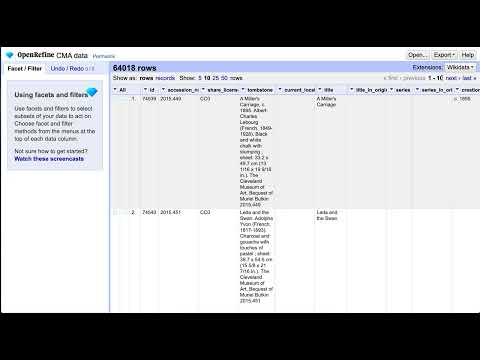

In [9]:
from IPython.display import YouTubeVideo, HTML

display(HTML("<h4>Video - Using  OpenRefine to extract Ruskin record from CMA data</h4>"))

YouTubeVideo('npVMbybZ3p8', width=1024, height=576)

### Collection Data for John Ruskin

The following table shows the relevant collection input data for illustration, and a digital image of the artwork is shown beneath.


In [10]:
#  baseURI for JSON-LD document
baseURI = "https://clevelandart.org/art/"
file = './data/cma/input/ruskin.csv'
#mpg = pd.read_csv(file)
#mpg.head()

display(pd.DataFrame(pd.read_csv(file), index=[0]).T)

0
id                                                                      154494
accession_number                                                       1989.14
share_license_status                                                       CC0
tombstone                    Budding Sycamore, c. 1876. John Ruskin (Britis...
current_location                                                           NaN
title                                                         Budding Sycamore
title_in_original_language                                                 NaN
series                                                                     NaN
series_in_original_language                                                NaN
creation_date                                                          c. 1876
creation_date_earliest                                                    1871
creation_date_latest                                                      1881
creators                              John Ruskin (British, 1819-1900), artist
culture                                                  England, 19th century
technique                           black and gray wash, gouache, and graphite
support_materials                  thick, moderately textured cream wove paper
department                                                            Drawings
collection                                                        DR - British
type                                                                   Drawing
measurements                     Sheet: 34.8 x 44.8 cm (13 11/16 x 17 5/8 in.)
state_of_the_work                                                          NaN
edition_of_the_work                                                        NaN
creditline                           Andrew R. and Martha Holden Jennings Fund
copyright                                                                  NaN
inscriptions                 signed and inscribed, in brown ink, at lower r...
exhibitions                  CURRENT: The Year in Review for 1989 (Feb 06, ...
provenance                   G.R. Roxburgh (?-?); (Artemis Fine Arts, Londo...
find_spot                                                                  NaN
related_works                                                              NaN
former_accession_numbers                                                    []
fun_fact                     This drawing was used as an illustration in Jo...
digital_description          The most influential art critic in Britain dur...
wall_description             The most influential art critic in Britain dur...
external_resources                    {'wikidata': [], 'internet_archive': []}
citations                    Cook, Edward Tyas and Alexander Wedderburn. <e...
catalogue_raisonne                                                         NaN
url                                       https://clevelandart.org/art/1989.14
image_web                    https://openaccess-cdn.clevelandart.org/1989.1...
image_print                  https://openaccess-cdn.clevelandart.org/1989.1...
image_full                   https://openaccess-cdn.clevelandart.org/1989.1...
updated_at                                          2021-03-27 12:16:10.046000

Budding Sycamore


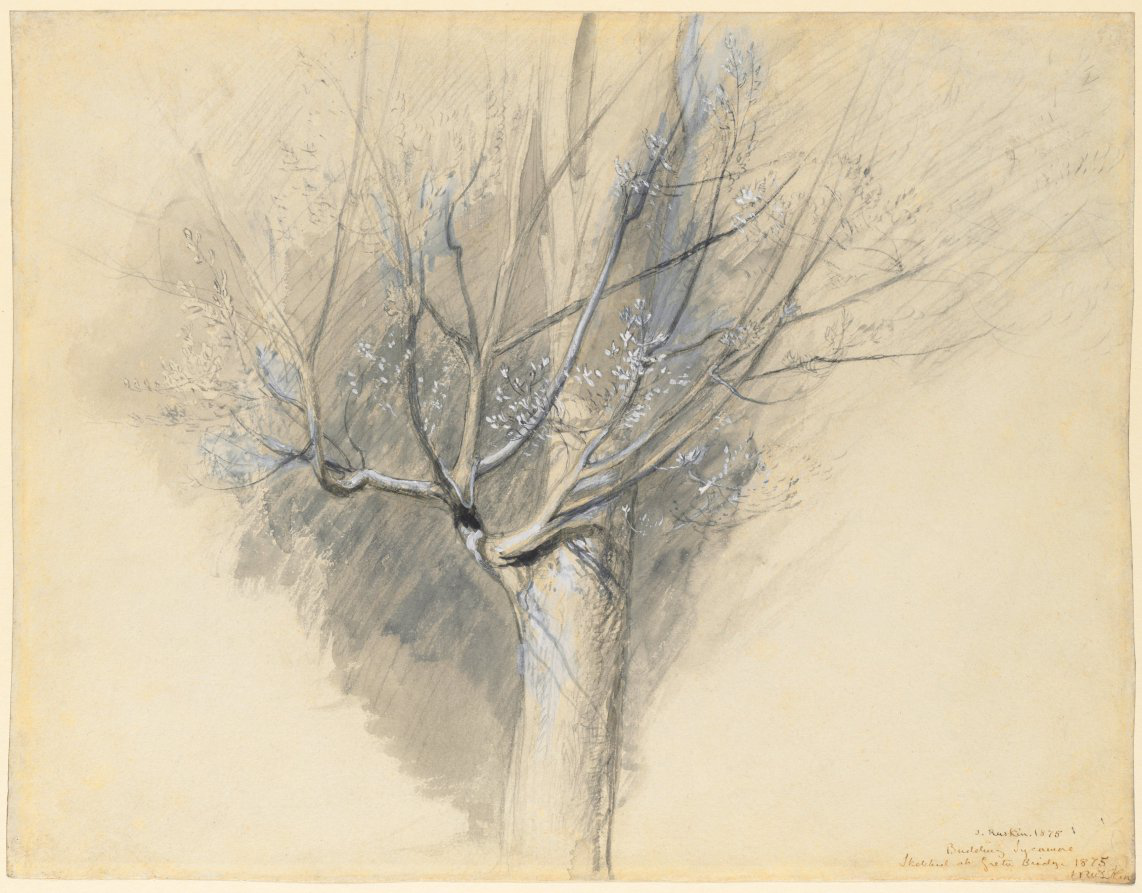

In [11]:
try:
    from PIL import Image
except:
    %pip install Pillow
    from PIL import Image
    
import requests

url = "https://openaccess-cdn.clevelandart.org/1989.14/1989.14_web.jpg"
image = Image.open(requests.get(url, stream=True).raw)

print("Budding Sycamore")
image

### Remove Byte Order Marks and Define Data Mapping

`mapp` holds the data mapping between entities in the Linked Art data model and the CMA data model

In [12]:

#remove BOM
s = open(file, mode='r', encoding='utf-8-sig').read()
open(file, mode='w', encoding='utf-8').write(s)

mapp =  {
    "id":"id",
    "accession_number":"accession_number",
    "accession_date": "",
    "classification" : "type",
    "title": "title",
    "alt_title": "title_in_original_language",
    "notes": "tombstone",
    "date_created":"creation_date",
    "date_created_earliest": "creation_date_earliest",
    "date_created_latest": "creation_date_latest",
    "created_period":"culture",
    "created_dynasty":"",
    "created_inscriptions":"inscriptions",
    "created_notes": "fun_fact",
    "creator":"creator",
    "physical_medium": "Medium",
    "physical_style": "",
    "physical_technique": "technique",
    "physical_description": "",
    "physical_dimensions": "measurements",
    "created_provenance": "provenance" ,
    "credit_line": "creditline",
    "collection" : "department",
    "current_status" : "current_location",
    "current_owner": "",
    "creator": {"name": "John Ruskin"},
    "homepage": "url"
    
    
}

# display transposed dataframe of data mapping
display(pd.DataFrame(mapp, index=[0]).T)

0
id                                             id
accession_number                 accession_number
accession_date                                   
classification                               type
title                                       title
alt_title              title_in_original_language
notes                                   tombstone
date_created                        creation_date
date_created_earliest      creation_date_earliest
date_created_latest          creation_date_latest
created_period                            culture
created_dynasty                                  
created_inscriptions                 inscriptions
created_notes                            fun_fact
creator                                       NaN
physical_medium                            Medium
physical_style                                   
physical_technique                      technique
physical_description                             
physical_dimensions                  measurements
created_provenance                     provenance
credit_line                            creditline
collection                             department
current_status                   current_location
current_owner                                    
homepage                                      url

### Transform Collections Data to Linked Art JSON-LD

This next step uses the following to transform the collections data to Linked Art JSON-LD

- the data mapping
- custom coding in createObjProp()
- `cromulant` Python library
- custom coding in `la` including createObjDescription()

In [13]:
file = './data/cma/input/ruskin.csv'

# open collection data input file 
allObjects = csv.DictReader(open(file, mode='r',encoding='utf-8'))

# iterate through row - only 1 in this case 
for obj in allObjects:
    
    # create object property dictionary
    objProp = createObjProp(obj,mapp)

    id = objProp["id"]
    object_uri = baseURI + id
    
    # define "image_url" property
    objProp["image_url"] = "https://clevelandart.org/art/" + id
    
    objProp["creator"] = [{"id": baseURI +"creatorid/JohnRuskin" ,"name": "John Ruskin","role":"Artist"}]
                    
    # create Linked Art representation using `la` and cromulent
    objLA = la.createObjDesc(objProp,la.objTypes,object_uri)
    
    # write Linked Art to file 
    text_file = open(outputdir + "/" + id + ".json", "wt")
    
    # use cromulent to write file 
    n = text_file.write(factory.toString(objLA, compact=False))
    
    text_file.close()
    
    display(pd.DataFrame(objProp, index=[0]).T)
    
    
# custom coding to create dictionary to be used to create Linked Art JSON-LD
def createObjProp(obj,mapp):
    objProp = {}
    
    # iterate through keys in csv collection data input file
    csv_keys = list(obj.keys())
    for key in csv_keys:
        # iterate through the data mapping
        for prop in mapp:
            if key == mapp[prop]:
                
                if prop == "classification":
                    objProp[prop] = "Drawing"
                ## define custom mapping for the creator property
                else:
                    objProp[prop] = obj[key]
    return objProp 

0
id                                                                154494
accession_number                                                 1989.14
notes                  Budding Sycamore, c. 1876. John Ruskin (Britis...
current_status                                                          
title                                                   Budding Sycamore
alt_title                                                               
date_created                                                     c. 1876
date_created_earliest                                               1871
date_created_latest                                                 1881
created_period                                     England, 19th century
physical_technique            black and gray wash, gouache, and graphite
collection                                                      Drawings
classification                                                   Drawing
physical_dimensions        Sheet: 34.8 x 44.8 cm (13 11/16 x 17 5/8 in.)
credit_line                    Andrew R. and Martha Holden Jennings Fund
created_inscriptions   signed and inscribed, in brown ink, at lower r...
created_provenance     G.R. Roxburgh (?-?); (Artemis Fine Arts, Londo...
created_notes          This drawing was used as an illustration in Jo...
homepage               https://www.nga.gov/collection/art-object-page...
image_url                            https://clevelandart.org/art/154494
creator                {'id': 'https://clevelandart.org/art/creatorid...

In [14]:
with open('./src/js/visld.js', 'r') as _jscript:
        code = _jscript.read() + "var file = '" + outputdir +  "154494.json';var selector = '#viscma';visjsonld(file, selector); "
        display(Javascript(code))

<IPython.core.display.Javascript object>

<div id='viscma' style='height:100%;width:6000px'></div>

## Tate Museum

The Tate, is located in the UK and has three items by John Ruskin in its Collection data, published in its GitHub repository. The date are available in separate JSON files and in a CSV file. The exercise will use the [CSV file](https://github.com/tategallery/collection/blob/master/artwork_data.csv). 

- ruskin-an-olive-spray-and-two-leaf-outlines
 - [web page](https://www.tate.org.uk/art/artworks/ruskin-an-olive-spray-and-two-leaf-outlines-n02726)
 - [data file](https://raw.githubusercontent.com/tategallery/collection/master/artworks/n/027/n02726-13031.json)
- ruskin-the-north-west-angle-of-the-facade-of-st-marks-venice
 - [web page](https://www.tate.org.uk/art/artworks/ruskin-the-north-west-angle-of-the-facade-of-st-marks-venice-n02972) 
 - [data file](https://raw.githubusercontent.com/tategallery/collection/master/artworks/n/029/n02972-13032.json)  
- ruskin-view-of-bologna
 - [web page](https://www.tate.org.uk/art/artworks/ruskin-view-of-bologna-n03507) 
 - [data file](https://raw.githubusercontent.com/tategallery/collection/master/artworks/n/035/n03507-13033.json)  
 
 #### Further Reading 
 
-  [The Tate Collection GitHub repository](https://github.com/tategallery/collection)
- [The Tate Collection web page for artist John Ruskin](https://www.tate.org.uk/search?type=artwork&q=john+ruskin)
- [The Tate data file for artist John Ruskin](https://github.com/tategallery/collection/blob/master/artists/r/ruskin-john-465.json)
- [The Tate data file for artworks CSV file ](https://github.com/tategallery/collection/blob/master/artwork_data.csv)


### Collection Data for Ruskin

The collection data contained in the CSV file is extracted using OpenRefine in the same process as was used for the CMA data above. The resulting CSV file is shown below:

In [41]:
baseURI = "https://www.tate.org.uk/art/artworks/"
file = './data/tate/tate-artwork_data.csv'

mpg = pd.read_csv(file)
mpg.head()


id accession_number        artist artistRole  artistId  \
0  13031           N02726  Ruskin, John     artist       465   
1  13032           N02972  Ruskin, John     artist       465   
2  13033           N03507  Ruskin, John     artist       465   

                                               title        dateText  \
0               An Olive Spray and Two Leaf Outlines     before 1877   
1  The North-West Angle of the Facade of St Mark’...  date not known   
2                                    View of Bologna        c.1845–6   

                                   medium  \
0  Graphite, watercolour and ink on paper   
1       Watercolour and graphite on paper   
2            Ink and watercolour on paper   

                                          creditLine    year  acquisitionYear  \
0  Presented by Sir Claude Phillips in memory of ...  1831.0             1910   
1                     Presented by the Art Fund 1914     NaN             1914   
2                                     Purchased 1920  1845.0             1920   

              dimensions  width  height  depth units  inscription  \
0  support: 375 x 279 mm    375     279    NaN    mm          NaN   
1  support: 940 x 610 mm    940     610    NaN    mm          NaN   
2  support: 343 x 489 mm    343     489    NaN    mm          NaN   

   thumbnailCopyright                                       thumbnailUrl  \
0                 NaN  http://www.tate.org.uk/art/images/work/N/N02/N...   
1                 NaN  http://www.tate.org.uk/art/images/work/N/N02/N...   
2                 NaN  http://www.tate.org.uk/art/images/work/N/N03/N...   

                                                 url  
0  http://www.tate.org.uk/art/artworks/ruskin-an-...  
1  http://www.tate.org.uk/art/artworks/ruskin-the...  
2  http://www.tate.org.uk/art/artworks/ruskin-vie...

### Data Mapping for The Tate

The `mapp` below shows the data mapping between entities in The Tate data model and Linked Art data model

In [42]:
mapp =  {
    "id":"id",
    "accession_number":"accession_number",
    "accession_date": "acquisitionYear",
    "classification" : "",
    "title": "title",
    "alt_title": "",
    "notes": "",
    "date_created":"dateText",
    "date_created_earliest": "year",
    "date_created_latest": "year",
    "created_period":"",
    "created_dynasty":"",
    "created_inscriptions":"inscription",
    "created_notes": "",
    "creator":"artist",
    "physical_medium": "medium",
    "physical_style": "",
    "physical_technique": "",
    "physical_description": "",
    "physical_dimensions": "dimensions",
    "created_provenance": "" ,
    "credit_line": "creditLine",
    "collection" : "Department",
    "current_status" : "",
    "current_owner": "Tate Museum",
    "image_url":"thumbnailUrl",
    "homepage" : "url"
}

# display transposed dataframe of data mapping
display(pd.DataFrame(mapp, index=[0]).T)

0
id                                   id
accession_number       accession_number
accession_date          acquisitionYear
classification                         
title                             title
alt_title                              
notes                                  
date_created                   dateText
date_created_earliest              year
date_created_latest                year
created_period                         
created_dynasty                        
created_inscriptions        inscription
created_notes                          
creator                          artist
physical_medium                  medium
physical_style                         
physical_technique                     
physical_description                   
physical_dimensions          dimensions
created_provenance                     
credit_line                  creditLine
collection                   Department
current_status                         
current_owner               Tate Museum
image_url                  thumbnailUrl
homepage                            url

### Transform Tate Collection Data to Linked Art 

This next step uses the following to transform the collections data to Linked Art JSON-LD

- the data mapping `mapp`
- custom coding in createObjProp()
- `cromulant` Python library
- custom coding in `la` including createObjDescription()

In [43]:
file = './data/tate/tate-artwork_data.csv'

#remove BOM
s = open(file, mode='r', encoding='utf-8-sig').read()
open(file, mode='w', encoding='utf-8').write(s)

selectOptions = []
selectOptions.append(("Please select an artwork", ""))


# open collection data input file 
allObjects = csv.DictReader(open(file, mode='r',encoding='utf-8'))

# iterate through row - only 1 in this case 
for obj in allObjects:
    
    # create object property dictionary
    objProp = createObjProp(obj,mapp)
    id = objProp["id"]
    object_uri = baseURI + id
    
    objProp["classification"] = "Painting"
    
    
    objProp["creator"] = [{"id": baseURI +"creatorid/" + obj["artistId"] ,"name": "John Ruskin","role":"Artist"}]
    
    # create Linked Art representation using `la` and cromulent
    objLA = la.createObjDesc(objProp,la.objTypes,object_uri)
    
    # write Linked Art to file 
    filename =  id + ".json"
    text_file = open(outputdir + "/" + filename, "wt")

    # use cromulent to write file 
    n = text_file.write(factory.toString(objLA, compact=False))
    
    text_file.close()
    
    # create drop down options for jsonld vis
    title = objProp["title"] + " (" + filename + ")" 
    selectOptions.append((title,filename))
    
    
# custom coding to create dictionary to be used to create Linked Art JSON-LD
def createObjProp(obj,mapp):
    objProp = {}
    
    # iterate through keys in csv collection data input file
    csv_keys = list(obj.keys())
    for key in csv_keys:
        # iterate through the data mapping
        for prop in mapp:
            if key == mapp[prop]:
                
                objProp[prop] = obj[key]
    return objProp 

### Visualisation of the Linked Art JSON-LD

The Linked Art JSON-LD representation can be viewed in a data visualisation below. Select an artwork from the dropdown menu.

In [45]:
def dropdown_eventhandler_tate(change):
    with open('./src/js/visld.js', 'r') as _jscript:
        outputdir = "./data/ruskin/output/json/"
        code = _jscript.read() + "var file = '" + outputdir + change.new + "';var selector = '#vistate';visjsonld(file, selector); "
        display(Javascript(code))
    
        with open( outputdir + change.new) as json_file:
    
                artwork = json.load(json_file)
                if ("representation" in artwork):
                    image = artwork["representation"][0]["id"]
                    display(Javascript("document.getElementById('artworktate').src = '" + image  +   "';"))
                else:
                    display(Javascript("document.getElementById('artworktate').src = '';"))
                    
selectObject = ipywidgets.Dropdown(options=selectOptions)
selectObject.observe(dropdown_eventhandler_tate, names='value')

display(selectObject)

Dropdown(options=(('Please select an artwork', ''), ('An Olive Spray and Two Leaf Outlines (13031.json)', '130…

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<div><img  id="artworktate" src=""/></div>

<div id='vistate' style='height:100%;width:6000px'></div>

## Harvard Art Museum

The Havard Art Museum collection includes several works by John Ruskin:

[Harvard Art Museum John Ruskin page](https://harvardartmuseums.org/collections/person/28419?person=28419)


- The collection data are available via an [API](https://github.com/harvardartmuseums/api-docs)
 - An API key is needed to query the API.

To retrieve the collection data for John Ruskin, the API is called with the following code 

<pre>
uri = "https://api.harvardartmuseums.org/object?person=28419&apikey=" + key
</pre>


The script below iterates through the results and writes the JSON response to local JSON files.

#### Further Reading

- [Harvard Art Museum API documentation](https://github.com/harvardartmuseums/api-docs)
- [Harvard Art Museum John Ruskin page](https://harvardartmuseums.org/collections/person/28419?person=28419)

In [46]:
import urllib3

http = urllib3.PoolManager()

keyfile = "data/ruskin/input/key.txt"

# Find all of the objects with the word "cat" in the title and return only a few fields per record
r = http.request('GET', 'https://api.harvardartmuseums.org/object',
    fields = {
        'apikey': '8def5994-1631-4345-bed0-f9385bdd67c7',
        'person':28419 ,
    })

In [47]:
try:
    import requests
except:
    %pip install requests
    import requests

apidocs = "https://github.com/harvardartmuseums/api-docs"

keyfile = "data/ruskin/input/key.txt"
key = open(keyfile, mode='r', encoding='utf-8-sig').read()
uri = "https://api.harvardartmuseums.org/object?person=28419&apikey=" + key

for page in range(1, 11):
    response = requests.get(uri + "&page=" + str(page))
    json_data = response.json()
    text_file = open( "./data/harvard/input/" + str(page) + ".json", "wt")
    n = text_file.write(json.dumps(json_data, indent=2))
    text_file.close()
    
    

### Example Collection Data Returned

An example record returned by the API is shown below

In [48]:
response = requests.get(uri + "&page=1")
json_data = response.json()
print(json.dumps(json_data["records"][0], indent=2))


{
  "copyright": null,
  "contextualtextcount": 0,
  "creditline": "Harvard Art Museums/Fogg Museum, Transfer from the Fine Arts Department, Harvard University",
  "accesslevel": 1,
  "dateoflastpageview": "2021-05-27",
  "classificationid": 23,
  "division": "European and American Art",
  "markscount": 0,
  "publicationcount": 0,
  "totaluniquepageviews": 17,
  "contact": "am_europeanamerican@harvard.edu",
  "colorcount": 9,
  "rank": 195836,
  "state": null,
  "id": 93100,
  "verificationleveldescription": "Good. Object is well described and information is vetted",
  "period": null,
  "images": [
    {
      "date": "2008-06-13",
      "copyright": "President and Fellows of Harvard College",
      "imageid": 312241,
      "idsid": 20460228,
      "format": "image/jpeg",
      "description": null,
      "technique": null,
      "renditionnumber": "INV195646",
      "displayorder": 1,
      "baseimageurl": "https://nrs.harvard.edu/urn-3:HUAM:INV195646_dynmc",
      "alttext": null,
   

### Map Harvard Art Museum data model to Linked Art data model

The next step is to map the collection data model to the Linked Art data model with `mapp`:

In [49]:
try:
    import pandas as pd
except:
    %pip install pandas
    import pandas as pd
    
mapp =  {
    "id":"id",
    "accession_number":"objectnumber",
    "accession_date": "accessionyear",
    "classification" : "",
    "title": "title",
    "alt_title": "",
    "notes": "commentary",
    "date_created":"dated",
    "date_created_earliest": "",
    "date_created_latest": "",
    "created_period":"period",
    "created_dynasty":"century",
    "created_inscriptions":"",
    "created_notes": "",
    "creator":"people",
    "physical_medium": "medium",
    "physical_style": "",
    "physical_technique": "technique",
    "physical_description": "description",
    "physical_dimensions": "dimensions",
    "created_provenance": "provenance" ,
    "credit_line": "creditline",
    "collection" : "division",
    "classification": "classification",
    "current_status" : "",
    "current_owner": "Harvard Museum of Art",
    "image_url":"primaryimageurl",
    "homepage" : "url"
}

# display transposed dataframe of data mapping
display(pd.DataFrame(mapp, index=[0]).T)

0
id                                        id
accession_number                objectnumber
accession_date                 accessionyear
classification                classification
title                                  title
alt_title                                   
notes                             commentary
date_created                           dated
date_created_earliest                       
date_created_latest                         
created_period                        period
created_dynasty                      century
created_inscriptions                        
created_notes                               
creator                               people
physical_medium                       medium
physical_style                              
physical_technique                 technique
physical_description             description
physical_dimensions               dimensions
created_provenance                provenance
credit_line                       creditline
collection                          division
current_status                              
current_owner          Harvard Museum of Art
image_url                    primaryimageurl
homepage                                 url

### Transform Harvard Collection Data to Linked Art 

This next step uses the following to transform the collections data to Linked Art JSON-LD

- the JSON files downloaded further to call to Harvard API
- the data mapping
- custom coding in createObjProp()
- `cromulant` Python library
- custom coding in `la` including createObjDescription()


The script below
- iterates through the Harvard JSON files
-  read file into json object
- iterate through records
- create objProp for record using mapping and collection data
- additional coding
 - define image_url
 - if creator field is not empty
  - create linked art representation
  - write to file 

In [50]:
import re
import json
from lib import linkedart as la
try:
    import cromulent 
except:
    %pip install cromulent
    import cromulent
    
from cromulent.model import factory
baseURI = "https://www.harvardartmuseums.org/collections/object/"
outputdir = "./data/ruskin/output/json/"


images = {}
selectOptions = []
selectOptions.append(("Please select an artwork", ""))


def createObjPropHarvard(obj,mapp):

    objProp = {}
    csv_keys = list(obj.keys())
    for key in csv_keys:
        for prop in mapp:
            if key == mapp[prop]:
                if key == "dated":
                    
                    # look for year in value 
                    years = re.findall('(\d{4})', obj[key])
                    if len(years) == 1:
                        #objProp["date"] = years[0]
                        objProp["date_created_earliest"] = years[0]
                        objProp["date_created_latest"] = years[0]
                    elif len(years) == 2:
                       # objProp["dated"] = str(years[0]) + "-" + str(years[1])
                        objProp["date_created_earliest"] = years[0]
                        objProp["date_created_latest"] = years[1]
                    else:
                        # use Ruskins birth/death years
                        objProp["date_created_earliest"] = 1819
                        objProp["date_created_latest"] = 1900
                        
                if prop == "creator":
                    objProp["creator"] = ""
                    for person in obj[key]:
                         
                        if "personid" in person and person["personid"] == 28419 and person["role"] == "Artist": 
                            objProp[prop] = [{
                                "id": "https://harvardartmuseums.org/collections/person/" + str(person["personid"]),
                                "name": person["displayname"],
                                "role": "Artist"
                                
                                }]      
                else:
                    objProp[prop] = obj[key]
                    
    objProp["current_owner"] = {"name":"Harvard Art Museum",
                                "location":"Cambridge, MA",
                                "type": "http://vocab.getty.edu/aat/300312281" ,
                                "type_label": ""}
    return objProp 

# iterates through the Harvard JSON files
for x in range(1,11):
    
    filename = str(x) + ".json"
    with open("./data/harvard/input/" + filename) as json_file:
        
        # read file into json object
        data = json.load(json_file)
        
        # iterate through records
        for obj in data["records"]:
            
            # check that there is  person description with   "role": "Artist" and "personid": 28419, ie Ruskin
            isjohnruskin = False
            for person in obj["people"]:
                if person["role"] == "Artist" and person["personid"] == 28419:
                    isjohnruskin = True
            if isjohnruskin == False:
                continue
                
            # create objProp for record using mapping and collection data
            objProp=createObjPropHarvard(obj,mapp)
            id = str(objProp["id"])
            
            # define image_url 
            if "image_url" in objProp and objProp["image_url"] != "":
                images["https://www.harvardartmuseums.org/collections/object/" + id] = objProp["image_url"]
            
            # define creator
            if objProp["creator"] != "":
                
                # create drop down options for jsonld vis
                title = objProp["title"] + " (" + id + ".json)" 
                selectOptions.append((title, id + ".json"))
                
                # create obj description
                objLA = la.createObjDesc(objProp, la.objTypes, baseURI + id)
                
                # write to file 
                text_file = open(outputdir + "/" + id + ".json", "wt")
                n = text_file.write(factory.toString(objLA, compact=False))
                text_file.close()
                
                # print for illustration
print(objProp["title"])
display(pd.DataFrame(objProp, index=[0]).T)
    
           
            
            
    


0
credit_line            Harvard Art Museums/Fogg Museum, Gift of Samue...
collection                                     European and American Art
id                                                                298628
created_period                                                      None
accession_date                                                      1919
classification                                                  Drawings
image_url                 https://nrs.harvard.edu/urn-3:HUAM:38491_dynmc
notes                  A portion of this drawing is engraved, in reve...
physical_technique                                                  None
physical_description                                                None
physical_medium        Graphite, brown ink, and brown wash on cream w...
title                  Study of Portal and Carved Pinnacles, Cathedra...
created_provenance     Charles Eliot Norton, to; his daughters Sara, ...
date_created_earliest                                               1848
date_created_latest                                                 1848
date_created                                                        1848
creator                {'id': 'https://harvardartmuseums.org/collecti...
homepage               https://www.harvardartmuseums.org/collections/...
created_dynasty                                             19th century
accession_number                                                1919.504
physical_dimensions               48.1 x 36.2 cm (18 15/16 x 14 1/4 in.)
current_owner                                                        NaN

### Visualisation of the Linked Art JSON-LD

The Linked Art JSON-LD representation can be viewed in a data visualisation below. Select an artwork from the dropdown menu.

In [52]:
try:
    import ipywidgets
except:
    %pip install ipywidgets
    import ipywidgets

from ipywidgets import Layout, FileUpload 
from IPython.display import display, IFrame, HTML, Image, Javascript

def dropdown_eventhandler_tate(change):
    with open('./src/js/visld.js', 'r') as _jscript:
        outputdir = "./data/ruskin/output/json/"
        code = _jscript.read() + "var file = '" + outputdir + change.new + "';var selector = '#visharv';visjsonld(file, selector); "
        display(Javascript(code))
    
        with open( outputdir + change.new) as json_file:
    
                artwork = json.load(json_file)
                if ("representation" in artwork):
                    image = artwork["representation"][0]["id"]
                    display(Javascript("document.getElementById('artworkharv').src = '" + image  +   "';"))
                else:
                    display(Javascript("document.getElementById('artworkharv').src = '';"))
                    
selectObject = ipywidgets.Dropdown(options=selectOptions)
selectObject.observe(dropdown_eventhandler_tate, names='value')

display(selectObject)

Dropdown(options=(('Please select an artwork', ''), ('Pass of Faido (262409.json)', '262409.json'), ('Château …

<div><img  id="artworkharv" src=""/></div>

<div id='visharv' style='height:100%;width:6000px'></div>

## Rijksmuseum

The Rijksmuseum has an API can that can be queried for collection data. To query the API, it is necessary to register for a key.

The API query used:
<pre>
"https://www.rijksmuseum.nl/api/nl/collection?key=" + key + "&involvedMaker=John+Ruskin"
</pre>

The Rijksmuseum has two artworks, with digital images, by John Ruskin in its collection data.


#### Further Reading

- [Rijksmuseum](https://www.rijksmuseum.nl)
- [Rijksmuseum API](https://www.rijksmuseum.nl/api)
- [John Ruskin artworks at Rijksmuseum](https://www.rijksmuseum.nl/en/search?q=ruskin&f=1&p=1&ps=12&principalMaker=John%20Ruskin&st=Objects&ii=0)

In [53]:
# local data directory
rijksdir = "data/rijks/json/"


# base URI for JSON-LD representation
baseURI = "http://www.rijksmuseum.nl/nl/collectie/"

# API key
keyfile = "data/ruskin/input/keyrijks.txt"
key = open(keyfile, mode='r', encoding='utf-8-sig').read()
# API Query
url = "https://www.rijksmuseum.nl/api/nl/collection?key=" + key + "&involvedMaker=John+Ruskin"

# query result to data var
response = requests.get(url)
data = response.json()

# iterate through data results
for artwork in data["artObjects"]:
    
    # if no image, do not include 
    if artwork["hasImage"] == False:
        continue
        
    # if artist is not john ruskin continue
    if artwork["principalOrFirstMaker"] != "John Ruskin":
        continue
        
    # write json file to local rijks data directory
    text_file = open( rijksdir + artwork["id"] + ".json", "wt")
    text_file.write(json.dumps(artwork, indent=2))
    
    print(json.dumps(artwork, indent=2))
    text_file.close()

{
  "links": {
    "self": "http://www.rijksmuseum.nl/api/nl/collection/RP-T-1957-335",
    "web": "http://www.rijksmuseum.nl/nl/collectie/RP-T-1957-335"
  },
  "id": "nl-RP-T-1957-335",
  "objectNumber": "RP-T-1957-335",
  "title": "Gezicht op S. Anastasia te Verona, over de Adige",
  "hasImage": true,
  "principalOrFirstMaker": "John Ruskin",
  "longTitle": "Gezicht op S. Anastasia te Verona, over de Adige, John Ruskin, 1829 - 1900",
  "showImage": true,
  "permitDownload": true,
  "webImage": {
    "guid": "c366d216-9aa1-4cb5-bbe5-fefa51f8e641",
    "offsetPercentageX": 0,
    "offsetPercentageY": 0,
    "width": 2500,
    "height": 1695,
    "url": "https://lh3.googleusercontent.com/X0Xc5cER3eTrpNyqH4kg3ne-ewai_nBqFdSI-EZPZ4N-lE6rn1OAUBckEHQSFyafcGcFpiX99QU4STEXWbB43KsnAbi3=s0"
  },
  "headerImage": {
    "guid": "84416aa1-5880-4751-ab94-72000580cd03",
    "offsetPercentageX": 0,
    "offsetPercentageY": 0,
    "width": 1920,
    "height": 460,
    "url": "https://lh3.googleusercon

### Mapping to Linked Art Data Model

In [54]:
# data mapping   
mapp = {
    
    "id":"id",
    "accession_number":"objectNumber",
    "classification" : "",
    "title": "title",
    "alt_title": "longTitle",
    "notes": "",
    "date_created":"",
    "date_created_earliest": "",
    "date_created_latest": "",
    "created_period":"",
    "created_dynasty":"",
    "created_inscriptions":"",
    "created_notes": "",
    "creator":"principalOrFirstMaker",
    "physical_medium": "",
    "physical_style": "",
    "physical_technique": "",
    "physical_description": "",
    "physical_dimensions": "",
    "created_provenance": "" ,
    "credit_line": "",
    "collection" : "",
    "classification": "",
    "current_status" : "",
    "current_owner": "",
    "image_url":"",
    "homepage" : ""
}

# display transposed dataframe of data mapping
display(pd.DataFrame(mapp, index=[0]).T)

0
id                                        id
accession_number                objectNumber
classification                              
title                                  title
alt_title                          longTitle
notes                                       
date_created                                
date_created_earliest                       
date_created_latest                         
created_period                              
created_dynasty                             
created_inscriptions                        
created_notes                               
creator                principalOrFirstMaker
physical_medium                             
physical_style                              
physical_technique                          
physical_description                        
physical_dimensions                         
created_provenance                          
credit_line                                 
collection                                  
current_status                              
current_owner                               
image_url                                   
homepage

In [55]:
import os

selectOptions = []
selectOptions.append(("Please select an artwork", ""))



def createObjProp(obj,mapp):
    objProp = {}
    csv_keys = list(obj.keys())
    for key in csv_keys:
        for prop in mapp:
            if key == mapp[prop]:
                if prop == "creator":
                    objProp["creator"] = ""
                    for person in obj[key]:
                        
                        if "personid" in person and person["personid"] == 28419 and person["role"] == "Artist": 
                            objProp[prop] = [{   "id": str(person["personid"]),   "name": person["displayname"],   "role": "Artist"  }]      
                else:
                    objProp[prop] = obj[key]
                    
                    
    objProp["current_owner"] =  {
                                            "name":"Rijksmuseum",
                                            "location":"Amsterdam, Netherlands",
                                            "type": "http://vocab.getty.edu/aat/300312281" ,
                                            "type_label": "Museum"
                                        }
    
    objProp["image_url"] = obj["webImage"]["url"]
    
    return objProp   


file_list=os.listdir(rijksdir)
for file in file_list:
    with open(rijksdir + file) as json_file:
        obj = json.load(json_file)
        objProp=createObjProp(obj,mapp)
        
        objProp["creator"] = [{   "id": "http://www.rijksmuseum.nl/nl/collectie/28419" ,   "name": "John Ruskin",   "role": "Artist"  }]
        objProp["classification"] = "Painting"
        objProp["homepage"] = obj["links"]["web"]
        
        if objProp["creator"] != "":
           
            id = str(objProp["id"])
            
            object_uri = "http://www.rijksmuseum.nl/nl/collectie/" + str(objProp["accession_number"])
            
            # create drop down options for jsonld vis
            title = objProp["title"] + " (" + id + ".json)" 
            selectOptions.append((title, id + ".json"))
            
            
            # create obj description
            objLA = la.createObjDesc(objProp,la.objTypes,object_uri)
            # write to file 
            text_file = open(outputdir + id + ".json", "wt")
            n = text_file.write(factory.toString(objLA, compact=False))
            text_file.close()
            
            print(objProp["title"])
            display(pd.DataFrame(objProp, index=[0]))


id accession_number                            title  \
0  nl-RP-T-1987-19     RP-T-1987-19  Bergkam aan het Meer van Genève   

                                             creator  \
0  {'id': 'http://www.rijksmuseum.nl/nl/collectie...   

                                           alt_title  current_owner  \
0  Bergkam aan het Meer van Genève, John Ruskin, ...            NaN   

                                           image_url classification  \
0  https://lh3.ggpht.com/SOPNNYPF1S5Ij-DKCcm7Aowe...       Painting   

                                            homepage  
0  http://www.rijksmuseum.nl/nl/collectie/RP-T-19...

id accession_number  \
0  nl-RP-T-1957-335    RP-T-1957-335   

                                              title  \
0  Gezicht op S. Anastasia te Verona, over de Adige   

                                             creator  \
0  {'id': 'http://www.rijksmuseum.nl/nl/collectie...   

                                           alt_title  current_owner  \
0  Gezicht op S. Anastasia te Verona, over de Adi...            NaN   

                                           image_url classification  \
0  https://lh3.googleusercontent.com/X0Xc5cER3eTr...       Painting   

                                            homepage  
0  http://www.rijksmuseum.nl/nl/collectie/RP-T-19...

### Visualisation of the Linked Art JSON-LD

The Linked Art JSON-LD representation can be viewed in a data visualisation below. Select an artwork from the dropdown menu.

In [56]:
try:
    import ipywidgets
except:
    %pip install ipywidgets
    import ipywidgets

from ipywidgets import Layout, FileUpload 
from IPython.display import display, IFrame, HTML, Image, Javascript

def dropdown_eventhandler_tate(change):
    with open('./src/js/visld.js', 'r') as _jscript:
        outputdir = "./data/ruskin/output/json/"
        code = _jscript.read() + "var file = '" + outputdir + change.new + "';var selector = '#visrijks';visjsonld(file, selector); "
        display(Javascript(code))
    
        with open( outputdir + change.new) as json_file:
    
                artwork = json.load(json_file)
                if ("representation" in artwork):
                    image = artwork["representation"][0]["id"]
                    display(Javascript("document.getElementById('artworkrijks').src = '" + image  +   "';"))
                else:
                    display(Javascript("document.getElementById('artworkrijks').src = '';"))
                    
selectObject = ipywidgets.Dropdown(options=selectOptions)
selectObject.observe(dropdown_eventhandler_tate, names='value')

display(selectObject)

Dropdown(options=(('Please select an artwork', ''), ('Bergkam aan het Meer van Genève (nl-RP-T-1987-19.json)',…

<div><img  id="artworkrijks" src=""/></div>

<div id='visrijks' style='height:100%;width:6000px'></div>

## Ashmolean Museum

The Ashmolean Museum in Oxford, UK holds many artworks by the artist John Ruskin. At present, to retrieve collection data for the artworks it was necessary to screenscrape the web pages for the artworks. This was achieved with the Python library `BeautifulSoup`. From the documentation:

<blockquote>
Beautiful Soup is a Python library for pulling data out of HTML and XML files. It works with your favorite parser to provide idiomatic ways of navigating, searching, and modifying the parse tree. 
    </blockquote>
    
    
The HTML was derived from a collections search via https://collections.ashmolean.org/collection/search with the HTML page saved locally to a [data file]( ./data/ashmolean/ash.html).

#### Further Reading

- [BeautifulSoup Python library](https://www.crummy.com/software/BeautifulSoup/bs4/doc/)
- [Ashmolean Museum Collection search](https://collections.ashmolean.org/collection/search)
- [Ruskin search as HTML file](./data/ashmolean/ash.html)

In [57]:
import requests

try:
    from bs4 import BeautifulSoup
except:
    %pip install bs4
    from bs4 import BeautifulSoup
    
import re

#cromulent
from cromulent.model import factory
   
# custom linked art coding
from lib import linkedart as la

selectOptions = []
selectOptions.append(("Please select an artwork", ""))


baseURI = "https://collections.ashmolean.org/collection/"
ash_file = './data/ashmolean/ash.html'

# open HTML file
html_text = open(ash_file, 'r').read()

# create soup
soup = BeautifulSoup(html_text, 'html.parser')

# iterate through artwork descriptions in HTML
for artwork in soup.find_all('div',attrs={"class":"list-inner"}):
    
    # title
    title = artwork.find('h3').string
    
    # id
    id = artwork.find('h3').find('a').get('href')
    id = id[-6:]
    
    # creator
    creator = [{"id": "https://collections.ashmolean.org/collection/search/trigger/person_id/value/7800", "name":"John Ruskin","role":"Artist"}]
    
    # accession number
    accession_number = artwork.find('span').string
    accession_number = accession_number.replace("Accession no. ", "")
    
    # image url
    image_url = artwork.find("img").get("src")
    
    # date created
    date_created = artwork.find("p").string
    date_created = date_created.replace("Date: ","")
    
    objProp = {
        "classification":"",
        "homepage":"https://collections.ashmolean.org/collection/browse-9148/object/" + id,
        "id":id,
        "title":title,
        "creator":creator,
        "accession_number":accession_number,
        "image_url":image_url,
        "date_created":date_created,
        "current_owner" : {"name":"Ashmolean Museum",
                                "location":"Oxford, England, UK",
                                "type": "http://vocab.getty.edu/aat/300312281" ,
                                "type_label": ""}
    }
    
    # look for year in value 
    years = re.findall('(\d{4})', date_created)
    if len(years) == 1:
                        
        objProp["date_created_earliest"] = years[0]
        objProp["date_created_latest"] = years[0]
    elif len(years) == 2:                
        objProp["date_created_earliest"] = years[0]
        objProp["date_created_latest"] = years[1]
    else:
        # use Ruskins birth/death years
        objProp["date_created_earliest"] = 1819
        objProp["date_created_latest"] = 1900
    
    
    object_uri = baseURI + id
    
      # create drop down options for jsonld vis
    title = objProp["title"] + " (" + objProp["id"] + ".json)" 
    selectOptions.append((title, objProp["id"] + ".json"))
    
    objLA = la.createObjDesc(objProp,la.objTypes,object_uri)
    
    # write to file 
    text_file = open(outputdir + objProp["id"] + ".json", "wt")
    n = text_file.write(factory.toString(objLA, compact=False))
    text_file.close()
    
    display(objProp["title"])
    display(pd.DataFrame(objProp, index=[0]))




'The Tower of Gloucester Cathedral'

classification                                           homepage      id  \
0                 https://collections.ashmolean.org/collection/b...  159710   

                               title  \
0  The Tower of Gloucester Cathedral   

                                             creator accession_number  \
0  {'id': 'https://collections.ashmolean.org/coll...    WA.RS.RUD.087   

                                           image_url date_created  \
0  https://collections.ashmolean.org/media/ashmol...         1832   

   current_owner date_created_earliest date_created_latest  
0            NaN                  1832                1832

'Near Bassano, Brenner'

classification                                           homepage      id  \
0                 https://collections.ashmolean.org/collection/b...  /48683   

                   title                                            creator  \
0  Near Bassano, Brenner  {'id': 'https://collections.ashmolean.org/coll...   

  accession_number                                          image_url  \
0       WA1949.253  https://collections.ashmolean.org/media/ashmol...   

  date_created  current_owner date_created_earliest date_created_latest  
0         1835            NaN                  1835                1835

'Bergamo and the Alps, from the road to Brescia'

classification                                           homepage      id  \
0                 https://collections.ashmolean.org/collection/b...  /48682   

                                            title  \
0  Bergamo and the Alps, from the road to Brescia   

                                             creator accession_number  \
0  {'id': 'https://collections.ashmolean.org/coll...       WA1949.252   

                                           image_url date_created  \
0  https://collections.ashmolean.org/media/ashmol...         1835   

   current_owner date_created_earliest date_created_latest  
0            NaN                  1835                1835

'Bellagio, Lago di Como'

classification                                           homepage      id  \
0                 https://collections.ashmolean.org/collection/b...  /48685   

                    title                                            creator  \
0  Bellagio, Lago di Como  {'id': 'https://collections.ashmolean.org/coll...   

  accession_number                                          image_url  \
0       WA1949.255  https://collections.ashmolean.org/media/ashmol...   

  date_created  current_owner date_created_earliest date_created_latest  
0         1835            NaN                  1835                1835

'End of the Lake of Lecco'

classification                                           homepage      id  \
0                 https://collections.ashmolean.org/collection/b...  /48684   

                      title  \
0  End of the Lake of Lecco   

                                             creator accession_number  \
0  {'id': 'https://collections.ashmolean.org/coll...       WA1949.254   

                                           image_url date_created  \
0  https://collections.ashmolean.org/media/ashmol...         1835   

   current_owner date_created_earliest date_created_latest  
0            NaN                  1835                1835

'Axmouth Landslip from Dolands Farm'

classification                                           homepage      id  \
0                 https://collections.ashmolean.org/collection/b...  125702   

                                title  \
0  Axmouth Landslip from Dolands Farm   

                                             creator accession_number  \
0  {'id': 'https://collections.ashmolean.org/coll...        WA2000.86   

                                           image_url date_created  \
0  https://collections.ashmolean.org/media/ashmol...      c. 1839   

   current_owner date_created_earliest date_created_latest  
0            NaN                  1839                1839

'Study for Detail of the Piazza delle Erbe, Verona'

classification                                           homepage      id  \
0                 https://collections.ashmolean.org/collection/b...  159601   

                                               title  \
0  Study for Detail of the Piazza delle Erbe, Verona   

                                             creator accession_number  \
0  {'id': 'https://collections.ashmolean.org/coll...    WA.RS.REF.062   

                                           image_url date_created  \
0  https://collections.ashmolean.org/media/ashmol...  19 May 1841   

   current_owner date_created_earliest date_created_latest  
0            NaN                  1841                1841

'The Palazzo Contarini-Fasan, Venice'

classification                                           homepage      id  \
0                 https://collections.ashmolean.org/collection/b...  159604   

                                 title  \
0  The Palazzo Contarini-Fasan, Venice   

                                             creator accession_number  \
0  {'id': 'https://collections.ashmolean.org/coll...    WA.RS.REF.065   

                                           image_url     date_created  \
0  https://collections.ashmolean.org/media/ashmol...  6 - 16 May 1841   

   current_owner date_created_earliest date_created_latest  
0            NaN                  1841                1841

'Outline of Leaves of Oak, touched with Colour'

classification                                           homepage      id  \
0                 https://collections.ashmolean.org/collection/b...  159452   

                                           title  \
0  Outline of Leaves of Oak, touched with Colour   

                                             creator accession_number  \
0  {'id': 'https://collections.ashmolean.org/coll...   WA.RS.ED.253.a   

                                           image_url date_created  \
0  https://collections.ashmolean.org/media/ashmol...  1842 - 1844   

   current_owner date_created_earliest date_created_latest  
0            NaN                  1842                1844

'Quick Study of Leaf Contour: Bramble'

classification                                           homepage      id  \
0                 https://collections.ashmolean.org/collection/b...  159803   

                                  title  \
0  Quick Study of Leaf Contour: Bramble   

                                             creator accession_number  \
0  {'id': 'https://collections.ashmolean.org/coll...    WA.RS.RUD.280   

                                           image_url   date_created  \
0  https://collections.ashmolean.org/media/ashmol...  probably 1843   

   current_owner date_created_earliest date_created_latest  
0            NaN                  1843                1843

'Leaf Contour: Laburnum'

classification                                           homepage      id  \
0                 https://collections.ashmolean.org/collection/b...  159804   

                    title                                            creator  \
0  Leaf Contour: Laburnum  {'id': 'https://collections.ashmolean.org/coll...   

  accession_number                                          image_url  \
0    WA.RS.RUD.281  https://collections.ashmolean.org/media/ashmol...   

    date_created  current_owner date_created_earliest date_created_latest  
0  probably 1843            NaN                  1843                1843

'Stone Pines at Sestri, Gulf of Genoa'

classification                                           homepage      id  \
0                 https://collections.ashmolean.org/collection/b...  159365   

                                  title  \
0  Stone Pines at Sestri, Gulf of Genoa   

                                             creator accession_number  \
0  {'id': 'https://collections.ashmolean.org/coll...     WA.RS.ED.022   

                                           image_url   date_created  \
0  https://collections.ashmolean.org/media/ashmol...  30 April 1845   

   current_owner date_created_earliest date_created_latest  
0            NaN                  1845                1845

'Part of the Façade of the destroyed Church of San Michele in Foro, Lucca, as it appeared in 1845'

classification                                           homepage      id  \
0                 https://collections.ashmolean.org/collection/b...  159407   

                                               title  \
0  Part of the Façade of the destroyed Church of ...   

                                             creator accession_number  \
0  {'id': 'https://collections.ashmolean.org/coll...     WA.RS.ED.083   

                                           image_url date_created  \
0  https://collections.ashmolean.org/media/ashmol...     May 1845   

   current_owner date_created_earliest date_created_latest  
0            NaN                  1845                1845

'Rough Sketch of Tree Growth: Macugnaga'

classification                                           homepage      id  \
0                 https://collections.ashmolean.org/collection/b...  159476   

                                    title  \
0  Rough Sketch of Tree Growth: Macugnaga   

                                             creator accession_number  \
0  {'id': 'https://collections.ashmolean.org/coll...  WA.RS.RUD.296.a   

                                           image_url   date_created  \
0  https://collections.ashmolean.org/media/ashmol...  4 August 1845   

   current_owner date_created_earliest date_created_latest  
0            NaN                  1845                1845

"Drawing of the Background of Raphael's 'Virgin and Child with the Infant Saint John' (The 'Madonna del Cardellino')"

classification                                           homepage      id  \
0                 https://collections.ashmolean.org/collection/b...  159572   

                                               title  \
0  Drawing of the Background of Raphael's 'Virgin...   

                                             creator accession_number  \
0  {'id': 'https://collections.ashmolean.org/coll...     WA.RS.ED.269   

                                           image_url        date_created  \
0  https://collections.ashmolean.org/media/ashmol...  probably June 1845   

   current_owner date_created_earliest date_created_latest  
0            NaN                  1845                1845

'Study of the Marble Inlaying on the Front of the Casa Loredan, Venice'

classification                                           homepage      id  \
0                 https://collections.ashmolean.org/collection/b...  159660   

                                               title  \
0  Study of the Marble Inlaying on the Front of t...   

                                             creator accession_number  \
0  {'id': 'https://collections.ashmolean.org/coll...    WA.RS.RUD.022   

                                           image_url  \
0  https://collections.ashmolean.org/media/ashmol...   

               date_created  current_owner date_created_earliest  \
0  September - October 1845            NaN                  1845   

  date_created_latest  
0                1845

'The Gryphon bearing the south Shaft of the west Entrance of the Duomo, Verona'

classification                                           homepage      id  \
0                 https://collections.ashmolean.org/collection/b...  159405   

                                               title  \
0  The Gryphon bearing the south Shaft of the wes...   

                                             creator accession_number  \
0  {'id': 'https://collections.ashmolean.org/coll...     WA.RS.ED.081   

                                           image_url date_created  \
0  https://collections.ashmolean.org/media/ashmol...  11 May 1846   

   current_owner date_created_earliest date_created_latest  
0            NaN                  1846                1846

'Part of the Façade of the destroyed Church of San Michele in Foro, Lucca, sketched in colour'

classification                                           homepage      id  \
0                 https://collections.ashmolean.org/collection/b...  159408   

                                               title  \
0  Part of the Façade of the destroyed Church of ...   

                                             creator accession_number  \
0  {'id': 'https://collections.ashmolean.org/coll...     WA.RS.ED.084   

                                           image_url           date_created  \
0  https://collections.ashmolean.org/media/ashmol...  30 June - 1 July 1846   

   current_owner date_created_earliest date_created_latest  
0            NaN                  1846                1846

'Lateral View of the Façade San Michele in Foro, Lucca'

classification                                           homepage      id  \
0                 https://collections.ashmolean.org/collection/b...  159409   

                                               title  \
0  Lateral View of the Façade San Michele in Foro...   

                                             creator accession_number  \
0  {'id': 'https://collections.ashmolean.org/coll...     WA.RS.ED.085   

                                           image_url           date_created  \
0  https://collections.ashmolean.org/media/ashmol...  30 June - 1 July 1846   

   current_owner date_created_earliest date_created_latest  
0            NaN                  1846                1846

'The Sculpture of a Dragon filling a Quatrefoil on the North Entrance of Rouen Cathedral'

classification                                           homepage      id  \
0                 https://collections.ashmolean.org/collection/b...  159671   

                                               title  \
0  The Sculpture of a Dragon filling a Quatrefoil...   

                                             creator accession_number  \
0  {'id': 'https://collections.ashmolean.org/coll...  WA.RS.RUD.042.a   

                                           image_url  date_created  \
0  https://collections.ashmolean.org/media/ashmol...  October 1848   

   current_owner date_created_earliest date_created_latest  
0            NaN                  1848                1848

'Euphemia (Effie) Ruskin'

classification                                           homepage      id  \
0                 https://collections.ashmolean.org/collection/b...  101252   

                     title                                            creator  \
0  Euphemia (Effie) Ruskin  {'id': 'https://collections.ashmolean.org/coll...   

  accession_number                                          image_url  \
0        WA1961.37  https://collections.ashmolean.org/media/ashmol...   

  date_created  current_owner date_created_earliest date_created_latest  
0  1846 - 1851            NaN                  1846                1851

"Ivy-Leaved Toadflax ('Oxford Ivy')"

classification                                           homepage      id  \
0                 https://collections.ashmolean.org/collection/b...  159362   

                                title  \
0  Ivy-Leaved Toadflax ('Oxford Ivy')   

                                             creator accession_number  \
0  {'id': 'https://collections.ashmolean.org/coll...     WA.RS.ED.019   

                                           image_url date_created  \
0  https://collections.ashmolean.org/media/ashmol...         1852   

   current_owner date_created_earliest date_created_latest  
0            NaN                  1852                1852

'Part of the Palazzo Priuli, Venice'

classification                                           homepage      id  \
0                 https://collections.ashmolean.org/collection/b...  159536   

                                title  \
0  Part of the Palazzo Priuli, Venice   

                                             creator accession_number  \
0  {'id': 'https://collections.ashmolean.org/coll...     WA.RS.ED.210   

                                           image_url   date_created  \
0  https://collections.ashmolean.org/media/ashmol...  probably 1852   

   current_owner date_created_earliest date_created_latest  
0            NaN                  1852                1852

'Study for Detail of the Sarcophagus and Canopy of the Tomb of Mastino II della Scala at Verona'

classification                                           homepage      id  \
0                 https://collections.ashmolean.org/collection/b...  159598   

                                               title  \
0  Study for Detail of the Sarcophagus and Canopy...   

                                             creator accession_number  \
0  {'id': 'https://collections.ashmolean.org/coll...    WA.RS.REF.059   

                                           image_url date_created  \
0  https://collections.ashmolean.org/media/ashmol...         1852   

   current_owner date_created_earliest date_created_latest  
0            NaN                  1852                1852

'The Exterior of the Ducal Palace, Venice'

classification                                           homepage      id  \
0                 https://collections.ashmolean.org/collection/b...  159606   

                                      title  \
0  The Exterior of the Ducal Palace, Venice   

                                             creator accession_number  \
0  {'id': 'https://collections.ashmolean.org/coll...    WA.RS.REF.067   

                                           image_url date_created  \
0  https://collections.ashmolean.org/media/ashmol...         1852   

   current_owner date_created_earliest date_created_latest  
0            NaN                  1852                1852

'Study of the North Gable of the Tomb of Mastino II della Scala, Verona'

classification                                           homepage      id  \
0                 https://collections.ashmolean.org/collection/b...  159712   

                                               title  \
0  Study of the North Gable of the Tomb of Mastin...   

                                             creator accession_number  \
0  {'id': 'https://collections.ashmolean.org/coll...    WA.RS.RUD.095   

                                           image_url        date_created  \
0  https://collections.ashmolean.org/media/ashmol...  probably June 1852   

   current_owner date_created_earliest date_created_latest  
0            NaN                  1852                1852

'Study of one of the Pinnacles of the Tomb of Mastino II della Scala, Verona'

classification                                           homepage      id  \
0                 https://collections.ashmolean.org/collection/b...  159714   

                                               title  \
0  Study of one of the Pinnacles of the Tomb of M...   

                                             creator accession_number  \
0  {'id': 'https://collections.ashmolean.org/coll...  WA.RS.RUD.097.a   

                                           image_url           date_created  \
0  https://collections.ashmolean.org/media/ashmol...  probably January 1852   

   current_owner date_created_earliest date_created_latest  
0            NaN                  1852                1852

'John Ruskin'

classification                                           homepage      id  \
0                 https://collections.ashmolean.org/collection/b...  /59248   

         title                                            creator  \
0  John Ruskin  {'id': 'https://collections.ashmolean.org/coll...   

  accession_number                                          image_url  \
0        WA2013.67  https://collections.ashmolean.org/media/ashmol...   

  date_created  current_owner date_created_earliest date_created_latest  
0  1853 - 1854            NaN                  1853                1854

"Etching of Turner's Drawing of 'Rietz, near Saumur'"

classification                                           homepage      id  \
0                 https://collections.ashmolean.org/collection/b...  159417   

                                               title  \
0  Etching of Turner's Drawing of 'Rietz, near Sa...   

                                             creator accession_number  \
0  {'id': 'https://collections.ashmolean.org/coll...     WA.RS.ED.101   

                                           image_url date_created  \
0  https://collections.ashmolean.org/media/ashmol...  before 1860   

   current_owner date_created_earliest date_created_latest  
0            NaN                  1860                1860

'Pine Forest on Mont Cenis'

classification                                           homepage      id  \
0                 https://collections.ashmolean.org/collection/b...  159576   

                       title  \
0  Pine Forest on Mont Cenis   

                                             creator accession_number  \
0  {'id': 'https://collections.ashmolean.org/coll...     WA.RS.ED.275   

                                           image_url date_created  \
0  https://collections.ashmolean.org/media/ashmol...  1854 - 1856   

   current_owner date_created_earliest date_created_latest  
0            NaN                  1854                1856

'Design for a Window in the University Museum, Oxford'

classification                                           homepage      id  \
0                 https://collections.ashmolean.org/collection/b...  176324   

                                               title  \
0  Design for a Window in the University Museum, ...   

                                             creator accession_number  \
0  {'id': 'https://collections.ashmolean.org/coll...        WA1931.47   

                                           image_url date_created  \
0  https://collections.ashmolean.org/media/ashmol...      c. 1855   

   current_owner date_created_earliest date_created_latest  
0            NaN                  1855                1855

'Design for a window in the University Museum, Oxford'

classification                                           homepage      id  \
0                 https://collections.ashmolean.org/collection/b...  176325   

                                               title  \
0  Design for a window in the University Museum, ...   

                                             creator accession_number  \
0  {'id': 'https://collections.ashmolean.org/coll...        WA1931.49   

                                           image_url date_created  \
0  https://collections.ashmolean.org/media/ashmol...      c. 1855   

   current_owner date_created_earliest date_created_latest  
0            NaN                  1855                1855

'Design for a window in the University Museum, Oxford'

classification                                           homepage      id  \
0                 https://collections.ashmolean.org/collection/b...  176326   

                                               title  \
0  Design for a window in the University Museum, ...   

                                             creator accession_number  \
0  {'id': 'https://collections.ashmolean.org/coll...        WA1931.51   

                                           image_url date_created  \
0  https://collections.ashmolean.org/media/ashmol...      c. 1855   

   current_owner date_created_earliest date_created_latest  
0            NaN                  1855                1855

'Design for a window in the University Museum, Oxford'

classification                                           homepage      id  \
0                 https://collections.ashmolean.org/collection/b...  176327   

                                               title  \
0  Design for a window in the University Museum, ...   

                                             creator accession_number  \
0  {'id': 'https://collections.ashmolean.org/coll...        WA1931.52   

                                           image_url date_created  \
0  https://collections.ashmolean.org/media/ashmol...      c. 1855   

   current_owner date_created_earliest date_created_latest  
0            NaN                  1855                1855

'Design for a window in the University Museum, Oxford'

classification                                           homepage      id  \
0                 https://collections.ashmolean.org/collection/b...  176328   

                                               title  \
0  Design for a window in the University Museum, ...   

                                             creator accession_number  \
0  {'id': 'https://collections.ashmolean.org/coll...        WA1931.53   

                                           image_url date_created  \
0  https://collections.ashmolean.org/media/ashmol...      c. 1855   

   current_owner date_created_earliest date_created_latest  
0            NaN                  1855                1855

'Design for a window in the University Museum, Oxford'

classification                                           homepage      id  \
0                 https://collections.ashmolean.org/collection/b...  176329   

                                               title  \
0  Design for a window in the University Museum, ...   

                                             creator accession_number  \
0  {'id': 'https://collections.ashmolean.org/coll...        WA1931.54   

                                           image_url date_created  \
0  https://collections.ashmolean.org/media/ashmol...      c. 1855   

   current_owner date_created_earliest date_created_latest  
0            NaN                  1855                1855

'Design for a window in the University Museum, Oxford'

classification                                           homepage      id  \
0                 https://collections.ashmolean.org/collection/b...  176330   

                                               title  \
0  Design for a window in the University Museum, ...   

                                             creator accession_number  \
0  {'id': 'https://collections.ashmolean.org/coll...        WA1931.55   

                                           image_url date_created  \
0  https://collections.ashmolean.org/media/ashmol...      c. 1855   

   current_owner date_created_earliest date_created_latest  
0            NaN                  1855                1855

'Design for a window in the University Museum, Oxford'

classification                                           homepage      id  \
0                 https://collections.ashmolean.org/collection/b...  176331   

                                               title  \
0  Design for a window in the University Museum, ...   

                                             creator accession_number  \
0  {'id': 'https://collections.ashmolean.org/coll...        WA1931.56   

                                           image_url date_created  \
0  https://collections.ashmolean.org/media/ashmol...      c. 1855   

   current_owner date_created_earliest date_created_latest  
0            NaN                  1855                1855

'Design for a window in the University Museum, Oxford'

classification                                           homepage      id  \
0                 https://collections.ashmolean.org/collection/b...  176332   

                                               title  \
0  Design for a window in the University Museum, ...   

                                             creator accession_number  \
0  {'id': 'https://collections.ashmolean.org/coll...        WA1931.50   

                                           image_url date_created  \
0  https://collections.ashmolean.org/media/ashmol...      c. 1855   

   current_owner date_created_earliest date_created_latest  
0            NaN                  1855                1855

"Study in Neutral Tint of Turner's 'The Pass of Faido'"

classification                                           homepage      id  \
0                 https://collections.ashmolean.org/collection/b...  159582   

                                               title  \
0  Study in Neutral Tint of Turner's 'The Pass of...   

                                             creator accession_number  \
0  {'id': 'https://collections.ashmolean.org/coll...     WA.RS.ED.287   

                                           image_url date_created  \
0  https://collections.ashmolean.org/media/ashmol...  1846 - 1865   

   current_owner date_created_earliest date_created_latest  
0            NaN                  1846                1865

'Study of a few Blades of Grass as they Grew'

classification                                           homepage      id  \
0                 https://collections.ashmolean.org/collection/b...  159350   

                                         title  \
0  Study of a few Blades of Grass as they Grew   

                                             creator accession_number  \
0  {'id': 'https://collections.ashmolean.org/coll...     WA.RS.ED.006   

                                           image_url          date_created  \
0  https://collections.ashmolean.org/media/ashmol...  probably spring 1856   

   current_owner date_created_earliest date_created_latest  
0            NaN                  1856                1856

'Fribourg, Switzerland: Pen sketch'

classification                                           homepage      id  \
0                 https://collections.ashmolean.org/collection/b...  159427   

                               title  \
0  Fribourg, Switzerland: Pen sketch   

                                             creator accession_number  \
0  {'id': 'https://collections.ashmolean.org/coll...   WA.RS.ED.114.a   

                                           image_url  \
0  https://collections.ashmolean.org/media/ashmol...   

                      date_created  current_owner date_created_earliest  \
0  July or August - September 1856            NaN                  1856   

  date_created_latest  
0                1856

'Study of Young Leaves of Plane, in Light and Shade'

classification                                           homepage      id  \
0                 https://collections.ashmolean.org/collection/b...  159453   

                                               title  \
0  Study of Young Leaves of Plane, in Light and S...   

                                             creator accession_number  \
0  {'id': 'https://collections.ashmolean.org/coll...     WA.RS.ED.254   

                                           image_url   date_created  \
0  https://collections.ashmolean.org/media/ashmol...  probably 1857   

   current_owner date_created_earliest date_created_latest  
0            NaN                  1857                1857

'Finished Study of Agrimony Leaves'

classification                                           homepage      id  \
0                 https://collections.ashmolean.org/collection/b...  159454   

                               title  \
0  Finished Study of Agrimony Leaves   

                                             creator accession_number  \
0  {'id': 'https://collections.ashmolean.org/coll...   WA.RS.ED.255.a   

                                           image_url   date_created  \
0  https://collections.ashmolean.org/media/ashmol...  probably 1857   

   current_owner date_created_earliest date_created_latest  
0            NaN                  1857                1857

"Tracing of Turner's 'Hospice of the Great Saint Bernard'"

classification                                           homepage      id  \
0                 https://collections.ashmolean.org/collection/b...  159730   

                                               title  \
0  Tracing of Turner's 'Hospice of the Great Sain...   

                                             creator accession_number  \
0  {'id': 'https://collections.ashmolean.org/coll...    WA.RS.RUD.150   

                                           image_url   date_created  \
0  https://collections.ashmolean.org/media/ashmol...  probably 1857   

   current_owner date_created_earliest date_created_latest  
0            NaN                  1857                1857

'The Courtyard of a Late Gothic Wooden House at Abbeville'

classification                                           homepage      id  \
0                 https://collections.ashmolean.org/collection/b...  159340   

                                               title  \
0  The Courtyard of a Late Gothic Wooden House at...   

                                             creator accession_number  \
0  {'id': 'https://collections.ashmolean.org/coll...     WA.RS.ED.062   

                                           image_url date_created  \
0  https://collections.ashmolean.org/media/ashmol...         1858   

   current_owner date_created_earliest date_created_latest  
0            NaN                  1858                1858

### Visualisation of the Linked Art JSON-LD

The Linked Art JSON-LD representation can be viewed in a data visualisation below. Select an artwork from the dropdown menu.

In [59]:
try:
    import ipywidgets
except:
    %pip install ipywidgets
    import ipywidgets

from ipywidgets import Layout, FileUpload 
from IPython.display import display, IFrame, HTML, Image, Javascript

def dropdown_eventhandler_tate(change):
    with open('./src/js/visld.js', 'r') as _jscript:
        outputdir = "./data/ruskin/output/json/"
        code = _jscript.read() + "var file = '" + outputdir + change.new + "';var selector = '#visash';visjsonld(file, selector); "
        display(Javascript(code))
    
        with open( outputdir + change.new) as json_file:
    
                artwork = json.load(json_file)
                if ("representation" in artwork):
                    image = artwork["representation"][0]["id"]
                    display(Javascript("document.getElementById('artworkash').src = '" + image  +   "';"))
                else:
                    display(Javascript("document.getElementById('artworkash').src = '';"))
                    
selectObject = ipywidgets.Dropdown(options=selectOptions)
selectObject.observe(dropdown_eventhandler_tate, names='value')

display(selectObject)

Dropdown(options=(('Please select an artwork', ''), ('The Tower of Gloucester Cathedral (159710.json)', '15971…

<div><img  id="artworkash" src=""/></div>

<div id='visash' style='height:100%;width:6000px'></div>

# Transformation - End Result - Linked Art JSON-LD Files for Artworks by John Ruskin

The result of the transformation is a collection of Linked Art JSON-LD files for artworks by John Ruskin from various collections.

You can explore the Linked Art representation below in the JSON-LD visualisation:
- select an artwork from the dropdown menu to view the image and associated Linked Art JSON-LD visualisation

In [60]:
file_list=os.listdir(outputdir)
   
#for file in file_list:
  #  display(HTML("<a target='_new' href='" + outputdir + file +"'>" + file + "</a>"))


In [61]:
import ipywidgets
from ipywidgets import Layout, FileUpload 
from IPython.display import display, IFrame, HTML, Image
import os
import json
from IPython.core.display import Javascript        


def dropdown_eventhandler(change):
    with open('./src/js/visld.js', 'r') as _jscript:
        code = _jscript.read() + "var file = '" + outputdir + change.new + "';var selector = '#visfinal';visjsonld(file, selector); "
        display(Javascript(code))
    
        with open( outputdir + "/" + change.new) as json_file:
    
                artwork = json.load(json_file)
                if ("representation" in artwork):
                    image = artwork["representation"][0]["id"]
                    display(Javascript("document.getElementById('artworkfinal').src = '" + image   +   "';"))
                else:
                    display(Javascript("document.getElementById('artworkfinal').src = '';"))
                    

# directory that will contain updated Ruskin artwork representations including geo coords
dir = outputdir = "./data/ruskin/output/json/"

file_list=os.listdir(dir)

selectOptions = []
selectOptions.append(("Please select an artwork", ""))


# for each linked art json file
for file in file_list:
    # open file
    with open( dir + "/" + file) as json_file:
        artwork = json.load(json_file)  
        if artwork.get('_label') != None:
            title = artwork["_label"] + " (" + file + ")"
        else:
            title = " (" + file + ")"
       
        selectOptions.append((title,file))

In [62]:
selectObject = ipywidgets.Dropdown(options=selectOptions)
selectObject.observe(dropdown_eventhandler, names='value')

display(selectObject)

Dropdown(options=(('Please select an artwork', ''), ("Engraving of Ruskin's Drawing of the Petal Vault of a Sc…

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<div><img style="height:500px" id="artworkfinal" src=""/></div>

<div id='visfinal' style='height:100%;width:6000px'></div>